In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
data_train=pd.read_csv('data_train.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
Unnamed: 0    891 non-null int64
pclass        891 non-null object
survived      891 non-null int64
name          891 non-null object
sex           891 non-null object
age           702 non-null float64
sibsp         891 non-null int64
parch         891 non-null int64
ticket        891 non-null object
fare          891 non-null float64
cabin         200 non-null object
embarked      891 non-null object
boat          320 non-null object
body          80 non-null float64
home.dest     504 non-null object
dtypes: float64(3), int64(4), object(8)
memory usage: 104.5+ KB


# 数据处理

In [49]:
def fill_age(df):
    # 对age填充
    age_mean=df['age'].mean()
    age_std=df['age'].std()
    age_nan_count=df.age.isnull().sum()
    age_nan_list=np.random.randint(age_mean-age_std,age_mean+age_std,size=age_nan_count)
    df.age[pd.isnull(df['age'])]=age_nan_list
    df.age=df.age.astype('int')
    

In [50]:
def process_data(df):
    # 处理cabin
    df['has_cabin']=df['cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)
    
    # 处理pclass
    p_index=df['pclass'].unique().tolist()
    df['pclass']=df['pclass'].apply(lambda x: p_index.index(x))
    
    # 处理embarked
    e_index=df['embarked'].unique().tolist()
    df['embarked']=df['embarked'].apply(lambda x: e_index.index(x))
        
    # 处理sex
    df.loc[df['sex']=='male','sex']=1
    df.loc[df['sex']=='female','sex']=0
    
    #处理age
    fill_age(df)
    
    df.loc[df['age']<=15,'age']=0
    df.loc[(df['age']>15)&(df['age']<50),'age']=1
    df.loc[df['age']>=50,'age']=2
    
    
    # 合并sibsp和parch 到family
    df['family']=df['sibsp']+df['parch']

    
    # 丢弃无用列
    df=df.drop(['Unnamed: 0','boat','home.dest','ticket','body','name','fare','cabin'],axis=1)
    return df

In [51]:
data_train=process_data(data_train)
data_train

C:\Users\Alice\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,pclass,survived,sex,age,sibsp,parch,embarked,has_cabin,family
0,0,1,1,0,1,2,0,1,3
1,1,0,1,1,0,0,0,0,0
2,0,1,0,1,1,0,1,1,1
3,0,0,1,1,0,0,0,0,0
4,1,0,1,1,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...
886,0,0,1,1,0,0,1,1,0
887,1,0,1,1,0,0,0,0,0
888,1,0,1,1,0,0,0,0,0
889,0,0,1,1,0,0,0,0,0


## 随机森林建模

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
def module(X,y):
    # 划分验证集（0.2）和训练集（0.8）
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
    rfc_sur=RandomForestClassifier(n_estimators=100)
    rfc_sur.fit(X_train,y_train)
    
    print("train score:", rfc_sur.score(X_train, y_train))
    print("test score:", rfc_sur.score(X_test, y_test))
    
    return rfc_sur

    

## 学习曲线

In [53]:
from sklearn.model_selection import learning_curve
#绘制学习曲线，以确定模型的状况
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.show()

## 交叉验证

In [54]:
from sklearn.model_selection import cross_val_score
def cross_score(X,y,mod):
     #简单看看打分情况 
    scores=cross_val_score(mod,X,y,cv=5)
    print('交叉验证scores:',scores)
    print('交叉验证mean:',scores.mean())

## k折交叉验证

In [55]:
from sklearn.model_selection import KFold
def k_folder(X,y,mod):
    kf=KFold(10,True,1)
    out=[]
    folder=0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        mod.fit(X_train,y_train)
        score=mod.score(X_test,y_test)
        print('Fold {} accuracy : {}'.format(folder,score))
        out.append(score)
        folder+=1
    print('Mean accuracy : ',np.mean(out))

## (1)age用0填充，并且划分比较细

train score: 0.8609550561797753
test score: 0.7821229050279329


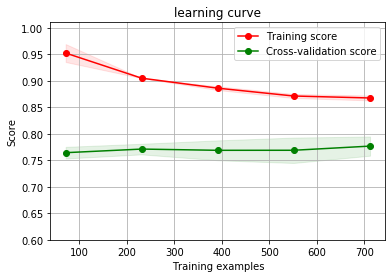

交叉验证scores: [0.79329609 0.77653631 0.77094972 0.75706215 0.80225989]
交叉验证mean: 0.7800208313606667


In [38]:
sur_df=data_train[['pclass','survived','sex','age','embarked','has_cabin','family']]
X=sur_df.drop('survived',axis=1).values
y=sur_df['survived'].values
rfc=module(X,y)
plot_learning_curve(rfc,'learning curve',X,y,ylim=(0.6,1.01))
cross_score(X,y,rfc)

可以看出来有点过拟合了，训练成绩高，测试成绩低。

## (2)对age 用均值上下方差的随机值填充 且只分三组

train score: 0.8328651685393258
test score: 0.8044692737430168


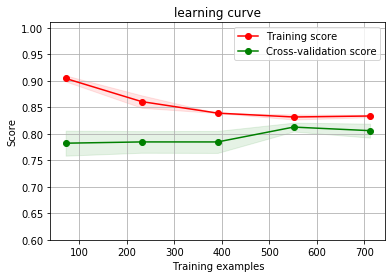

交叉验证scores: [0.82681564 0.80446927 0.79888268 0.78531073 0.8079096 ]
交叉验证mean: 0.8046775873496829


In [56]:
sur_df=data_train[['pclass','survived','sex','age','has_cabin','family']]
X=sur_df.drop('survived',axis=1).values
y=sur_df['survived'].values
rfc=module(X,y)
plot_learning_curve(rfc,'learning curve',X,y,ylim=(0.6,1.01))
cross_score(X,y,rfc)

In [57]:
k_folder(X,y,rfc)

Fold 0 accuracy : 0.7333333333333333
Fold 1 accuracy : 0.8089887640449438
Fold 2 accuracy : 0.7303370786516854
Fold 3 accuracy : 0.8539325842696629
Fold 4 accuracy : 0.7415730337078652
Fold 5 accuracy : 0.7865168539325843
Fold 6 accuracy : 0.8426966292134831
Fold 7 accuracy : 0.8314606741573034
Fold 8 accuracy : 0.8539325842696629
Fold 9 accuracy : 0.8202247191011236
Mean accuracy :  0.8002996254681648


k折交叉验证和模型直接得分差不多，随机森林投票得到结果的过程已经是无偏估计了，误差较小。

In [58]:
sur_df

,pclass,survived,sex,age,has_cabin,family
0,0,1,1,0,1,3
1,1,0,1,1,0,0
2,0,1,0,1,1,1
3,0,0,1,1,0,0
4,1,0,1,1,0,0
...,...,...,...,...,...,...
886,0,0,1,1,1,0
887,1,0,1,1,0,0
888,1,0,1,1,0,0
889,0,0,1,1,0,0


 对age 用均值上下方差的随机值填充


## (3) 超参数优化器：网格优化器

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
sur_df=data_train[['pclass','survived','sex','age','has_cabin','family']]
X=sur_df.drop('survived',axis=1).values
y=sur_df['survived'].values

params={'n_estimators': [6,9,20], 
              'max_features': ['log2', 'sqrt','auto'], 
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]}
grid_cv=GridSearchCV(RandomForestClassifier(),params,cv=5)
grid_cv=grid_cv.fit(X,y)

C:\Users\Alice\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [44]:
print('best score: {}\nbest params:{}'.format(grid_cv.best_score_,grid_cv.best_params_))

best score: 0.8204264870931538
best params:{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 20}


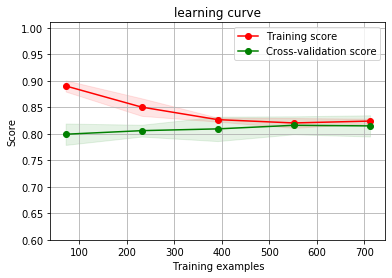

交叉验证scores: [0.84916201 0.81005587 0.78212291 0.79096045 0.81920904]
交叉验证mean: 0.8103020547296657


In [45]:
rfc_best=grid_cv.best_estimator_
plot_learning_curve(rfc_best,'learning curve',X,y,ylim=(0.6,1.01))
cross_score(X,y,rfc_best)

## 测试集

In [46]:
df_test=pd.read_csv('data_test.csv')
df_test=process_data(df_test)

sur_df=df_test[['pclass','survived','sex','age','has_cabin','family']]
X=sur_df.drop('survived',axis=1).values
y=sur_df['survived'].values
print('test score: ',rfc_best.score(X,y))

test score:  0.7822966507177034


C:\Users\Alice\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
